<a href="https://colab.research.google.com/github/sparsh2401/Weather-Prediction/blob/main/weather_model_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
categorical_cols = df.select_dtypes(include=['object','bool']).columns

In [ ]:
print("Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Data Types:
 Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type              int64
dtype: object

Missing Values:
 Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

Unique Values in Categorical Columns:
Cloud Cover: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Season: ['Winter' 'Spring' 'Summer' 'Autumn']
Location: ['inland' 'mountain' 'coastal']


In [ ]:
df[categorical_cols] = df[categorical_cols].fillna("Unknown").astype(str)


In [ ]:
df[categorical_cols]

,Cloud Cover,Season,Location
0,partly cloudy,Winter,inland
1,partly cloudy,Spring,inland
2,clear,Spring,mountain
3,clear,Spring,coastal
4,overcast,Winter,mountain
...,...,...,...
13195,overcast,Summer,mountain
13196,cloudy,Winter,coastal
13197,overcast,Autumn,coastal
13198,overcast,Winter,inland


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Model accuracy: 0.9093434343434343
Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.87      0.88      0.88       955
       Rainy       0.90      0.92      0.91       982
       Snowy       0.92      0.94      0.93      1033
       Sunny       0.94      0.89      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Top 5 Features:
Cloud Cover_clear: 0.2404
UV Index: 0.1960
Temperature: 0.1916
Visibility (km): 0.0824
Precipitation (%): 0.0711


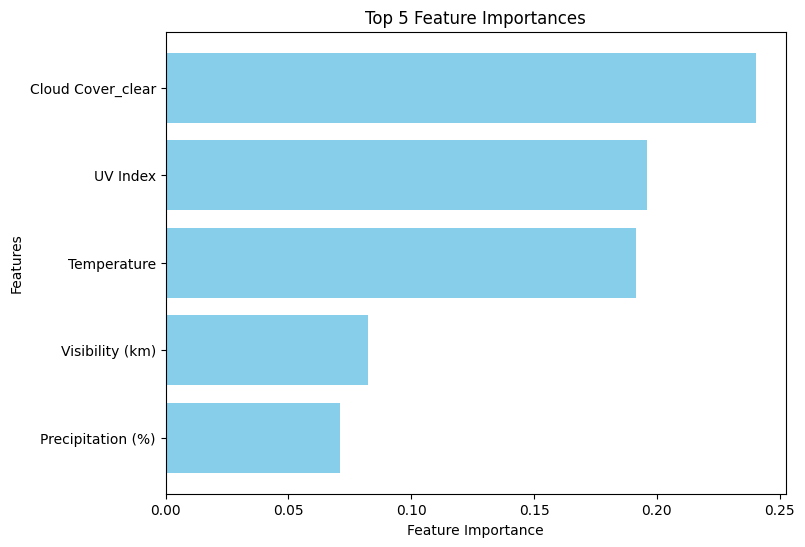

Model saved as weather_xgboost_model.pkl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load dataset (replace this with actual dataset)
df = pd.read_csv("weather_classification_data.csv")

# Define features and target
X = df.drop(columns=["Weather Type"], errors='ignore')
y = df["Weather Type"]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Identifying categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object']

# Column transformer to handle different data types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Define XGBoost classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")

# Create a pipeline to ensure proper data transformation
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Medium-Level Hyperparameter Tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model after Tuning
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions
preds = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print("Model accuracy:", accuracy)

# Fix: Convert `label_encoder.classes_` to string
target_names = [str(cls) for cls in label_encoder.classes_]

# Classification Report
report = classification_report(y_test, preds, target_names=target_names)
print("Classification Report:\n", report)

# Extract feature names correctly
preprocessor.fit(X_train)  # Ensure it's fitted before accessing feature names
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Get feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Extract top 5 features
top_5_idx = np.argsort(feature_importances)[-5:]
top_5_features = np.array(feature_names)[top_5_idx]
top_5_importances = feature_importances[top_5_idx]

# Display top 5 features
print("Top 5 Features:")
for feature, importance in zip(top_5_features[::-1], top_5_importances[::-1]):
    print(f"{feature}: {importance:.4f}")

# Plot top 5 feature importances
plt.figure(figsize=(8, 6))
plt.barh(top_5_features, top_5_importances, color="skyblue")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances')
plt.show()

# Save the best model
with open('weather_xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("Model saved as weather_xgboost_model.pkl")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode target variable (assuming classification task)
label_encoder = LabelEncoder()
df["Weather Type"] = label_encoder.fit_transform(df["Weather Type"])

# Separate features and target
X = df.drop("Weather Type", axis=1)
y = df["Weather Type"]

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Define hyperparameter grid for tuning XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of trees
    'subsample': [0.8, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used per tree
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")

# Apply GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance visualization
import matplotlib.pyplot as plt

feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
feature_importances = best_model.feature_importances_

# Sort feature importance
sorted_idx = np.argsort(feature_importances)[-10:]  # Top 10 important features

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances in XGBoost")
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
import pandas as pd
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ✅ Load dataset
df = pd.read_csv("weather_classification_data.csv")

# ✅ Define expected features
expected_features = [
    "Wind Speed", "Temperature", "UV Index", "Precipitation (%)",
    "Atmospheric Pressure", "Visibility (km)", "Humidity",
    "Season", "Cloud Cover", "Location"
]

# ✅ Ensure dataset contains all expected features
missing_features = set(expected_features) - set(df.columns)
if missing_features:
    raise ValueError(f"❌ Missing columns in dataset: {missing_features}")

# ✅ Separate numerical and categorical features
numerical_cols = [
    "Wind Speed", "Temperature", "UV Index", "Precipitation (%)",
    "Atmospheric Pressure", "Visibility (km)", "Humidity"
]
categorical_cols = ["Season", "Cloud Cover", "Location"]

# ✅ Define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Scale numerical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # One-hot encode categorical features
    ]
)

# ✅ Fit the preprocessor on data
preprocessor.fit(df[expected_features])

# ✅ Save preprocessor for later use
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

print("✅ Preprocessor trained and saved as preprocessor.pkl")


✅ Preprocessor trained and saved as preprocessor.pkl


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv("weather_classification_data.csv")

# Encode categorical features
label_encoders = {}
categorical_cols = ["Cloud Cover", "Season", "Location", "Weather Type"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=["Weather Type"])
y = df["Weather Type"]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naïve Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print accuracy of each model
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


In [ ]:
import pickle
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Ensure column names are correct
print("Columns in dataset:", df.columns)

# Define features and target
X = df.drop(columns=["Weather Type"], errors='ignore')
y = df["Weather Type"]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identifying the categorical and numerical columns
categorical_cols = [col for col in X.columns if df[col].dtype == 'object']
numerical_cols = [col for col in X.columns if df[col].dtype != 'object']

# Column transformer to handle different data types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Defining pipelines for different models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Training and evaluating models
for name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))


    with open(f'{name.replace(" ", "_").lower()}_model.pkl', 'wb') as file:
        pickle.dump(pipeline, file)

print("Models saved successfully.")


Columns in dataset: Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Weather Type'],
      dtype='object')
Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.82      0.84      0.83       955
       Rainy       0.86      0.85      0.86       982
       Snowy       0.88      0.94      0.91      1033
       Sunny       0.93      0.86      0.89       990

    accuracy                           0.87      3960
   macro avg       0.87      0.87      0.87      3960
weighted avg       0.87      0.87      0.87      3960

Random Forest Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       955
       Rainy       0.90      0.92      0.91       982
       Snowy       0.94      0.93      0.94      1033
       Sunny       0.95      0.90 

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['Cloudy' 'Rainy' 'Snowy' 'Sunny']

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ✅ Load dataset
data = pd.read_csv("weather_classification_data.csv")  # Ensure this file exists

# ✅ Define feature columns
numerical_features = ["Temperature", "Precipitation (%)", "Atmospheric Pressure",
                      "UV Index", "Visibility (km)", "Humidity", "Wind Speed"]
categorical_features = ["Season", "Cloud Cover", "Location"]

# ✅ Convert categorical features to 'category' type
for cat_col in categorical_features:
    data[cat_col] = data[cat_col].astype("category")

# ✅ Encode target variable (`y`)
label_encoder = LabelEncoder()
data["Weather Type"] = label_encoder.fit_transform(data["Weather Type"])  # Converts strings to numbers

# ✅ Save label encoder for later use in Streamlit app
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# ✅ Define features and target
X = data[numerical_features + categorical_features]
y = data["Weather Type"]  # Now it's numerical

# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# ✅ Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Ensure correct number of classes
    use_label_encoder=False,
    eval_metric="mlogloss"
)

# ✅ Full Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])

# ✅ Train the model
pipeline.fit(X_train, y_train)

# ✅ Save the model and preprocessor
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open("weather_xgboost_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ Model trained and saved successfully!")
